# Genetic algorithms for solving Quadratic Assigment Problems

## Problem definition

In [1]:
import numpy as np

# Defining the problem
class QAProblem:

    def __init__(self, n, distances, flows):
        self.n = n
        self.distances = distances
        self.flows = flows

    def trad_eval(self, solution):
        cost = 0.
        for i in range(self.n):
            for j in range(self.n):
                dist = self.distances[i][j]
                flow = self.flows[solution[i]][solution[j]]
                cost += flow * dist
        return cost

    def symm_eval(self, solution):
        cost = 0
        for i in range(self.n-1):
            for j in range(i+1, self.n):
                dist = self.distances[i][j]
                flow = self.flows[solution[i]][solution[j]]
                cost += 2*(flow * dist)
        return cost

    def __call__(self, solution):
        perm_flow = self.flows[solution,:][:,solution]
        return int(np.multiply(self.distances, perm_flow).sum())

    def create_from_file(path):
        with open(path, "r") as f:
            n = int(f.readline().strip())
            distances, flows = np.zeros((n, n), dtype=int), np.zeros((n, n), dtype=int)
            _ = f.readline()
            for i in range(n):
                flows[i,:] = (list(map(int, f.readline().split())))
            for j in range(n):
                distances[j,:] = (list(map(int, f.readline().split())))
        return QAProblem(n, distances, flows)

# Reading data

qaProblem = QAProblem.create_from_file(path="tai256c.dat")

print(np.shape(qaProblem.distances))
print(np.shape(qaProblem.flows))


(256, 256)
(256, 256)


### Testing evaluation approaches

In [2]:
# Testing evaluation approaches
import time

np.random.seed(123)


# Number of solutions (individuals)
pop_size = 50

# Creating the solution set, (population)
pop = [np.random.permutation(qaProblem.n) for i in range(pop_size)]

# Collecting fitness evaluations
pop_fits = np.zeros((pop_size, 3), dtype=int)


# Traditional approache
start = time.time()
fits = []
for ind in pop:
    fits.append(qaProblem.trad_eval(ind))
pop_fits[:, 0] = fits
end = time.time()
print(end - start)

# Exploiting symmetry
start = time.time()
fits = []
for ind in pop:
    fits.append(qaProblem.symm_eval(ind))
pop_fits[:, 1] = fits
end = time.time()
print(end - start)

# Exploiting numpy multiplication and sum
start = time.time()
fits = []
for ind in pop:
    fits.append(qaProblem(ind))
pop_fits[:, 2] = fits
end = time.time()
print(end - start)

# Checking fitness equallity between approaches

print((pop_fits[:,0] == pop_fits[:,1]).all())
print((pop_fits[:,0] == pop_fits[:,2]).all())
print((pop_fits[:,1] == pop_fits[:,2]).all())




2.276871919631958
1.124932050704956
0.014884233474731445
True
True
True


## Algorithm definition

In [4]:
def cross_order(parent1, parent2):
    l = len(parent1)
    par_size = l // 2
    
    start_point = np.random.randint(l)
    cop_points = (start_point + np.array(range(par_size))) % l
    end_point = (start_point + par_size) % l
    # rep_points = (end_point + np.array(range(l - par_size))) % l
    rep_points_all = (end_point + np.array(range(l))) % l
    rep_points = rep_points_all[0:(l - par_size)]

    off1 = np.zeros(l, dtype=int)
    off2 = np.zeros(l, dtype=int)

    off1[cop_points] = parent1[cop_points]
    off2[cop_points] = parent2[cop_points]

    parent2_cont = np.setdiff1d(parent2[rep_points_all], off1[cop_points], assume_unique=True)
    parent1_cont = np.setdiff1d(parent1[rep_points_all], off2[cop_points], assume_unique=True)

    off1[rep_points] = parent2_cont[0:(l - par_size)]
    off2[rep_points] = parent1_cont[0:(l - par_size)]

    return off1, off2



    
def mut_swap(individual, strength=1, inplace=True):
    if inplace:
        mut_ind = individual
    else:
        mut_ind = individual.copy()

    l = len(individual)
    for i in range(strength):
        r = np.random.permutation(l)[[0,1]]
        s,e = np.min(r), np.max(r)
        temp = mut_ind[s]
        mut_ind[s] = mut_ind[e]
        mut_ind[e] = temp
    
    return mut_ind



def selection_tournament(pop_fitness, perc_tourn=0.2):
    perc_tourn = max(0.1, perc_tourn)
    perc_tourn = min(1., perc_tourn)
    
    p_size = len(pop_fitness)

    tourn_size = int(np.ceil(perc_tourn * p_size))

    indx1 = np.random.permutation(p_size)[range(tourn_size)]
    best1indx = np.argmin(pop_fitness[indx1])
    true_best1_indx = indx1[best1indx]

    true_best2_indx = true_best1_indx

    while(true_best1_indx ==  true_best2_indx):
        indx2 = np.random.permutation(p_size)[range(tourn_size)]
        best2indx = np.argmin(pop_fitness[indx2])
        true_best2_indx = indx2[best2indx]

    return true_best1_indx, true_best2_indx


def replacement_best_n(pop_fitness, sel_size:int):
    return np.argsort(pop_fitness)[range(sel_size)]


class GAforQA:
    def __init__(self, qa_problem:QAProblem, pop_size:int=50, crossover_rate:float=0.9, mutation_rate:float=0.1) -> None:
        self.qa_problem = qa_problem
        self.pop_size = pop_size
        self.cross_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = np.empty((self.pop_size, self.qa_problem.n),  dtype=int)
        self.fitness = np.zeros(self.pop_size, dtype=int)

    def initialize(self):
        for i in range(self.pop_size):
            x = np.random.permutation(self.qa_problem.n)
            f = self.qa_problem(x)
            self.population[i,:] = x
            self.fitness[i] = f
            

    def run(self, max_runs, max_gens):

        stats_fitness = np.zeros((max_gens, max_runs), dtype=int)

        for r in range(max_runs):

            np.random.seed(r)

            self.initialize()

            best_fit = np.min(self.fitness)

            stats_fitness[0, r] = best_fit

            print("GEN:{:d}\tBestFit:{:d}".format(0, best_fit, abs(best_fit-44759294)))

            stag_times = 0

            for gen in range(1, max_gens):

                # Selecting pairs of parents

                offspring = []
                off_fitness = []

                for i in range(self.pop_size//2):
                    par1_idx, par2_idx = selection_tournament(self.fitness, perc_tourn=0.1)
                    par1 = self.population[par1_idx]
                    par2 = self.population[par2_idx]
                    if(np.random.random() < self.cross_rate):
                        off1, off2 = cross_order(par1, par2)
                    else:
                        off1, off2 = par1.copy(), par2.copy()

                    off1 = mut_swap(off1, np.random.randint(low=0, high=3))
                    off2 = mut_swap(off2, np.random.randint(low=0, high=3))

                    fit1 = self.qa_problem(off1)
                    fit2 = self.qa_problem(off2)

                    offspring.append(off1)
                    offspring.append(off2)
                    off_fitness.append(fit1)
                    off_fitness.append(fit2)

                    

                all_fits = np.append(self.fitness, off_fitness)
                all_pop = np.append(self.population, offspring, axis=0)
                
                rep_indxs = replacement_best_n(all_fits, self.pop_size)

                self.population = all_pop[rep_indxs]
                self.fitness = all_fits[rep_indxs]

                new_best_fit = self.fitness[0]

                if new_best_fit == best_fit:
                    stag_times += 1
                else:
                    stag_times = 0
                    best_fit = self.fitness[0]

                if stag_times > 10:
                    repindx = np.random.randint(low=self.pop_size-3, high=self.pop_size)
                    self.population[repindx] = np.random.permutation(self.qa_problem.n)
                    self.fitness[repindx] = self.qa_problem(self.population[repindx])
                    stag_times = 0

                stats_fitness[gen, r] = best_fit

                print("RUN:{:d}/{:d}\tGEN:{:d}/{:d}\tBestFit:{:d}\tError:{:d}".format(r+1, max_runs, gen+1, max_gens, best_fit, abs(best_fit-44759294)))
        
        return stats_fitness
            

ga_alg = GAforQA(qaProblem, pop_size=50)

results = ga_alg.run(max_runs=10, max_gens=100000)



GEN:0	BestFit:50234328
RUN:1/10	GEN:2/100000	BestFit:50234328	Error:5475034
RUN:1/10	GEN:3/100000	BestFit:50234328	Error:5475034
RUN:1/10	GEN:4/100000	BestFit:50234328	Error:5475034
RUN:1/10	GEN:5/100000	BestFit:50234328	Error:5475034
RUN:1/10	GEN:6/100000	BestFit:49546794	Error:4787500
RUN:1/10	GEN:7/100000	BestFit:49546794	Error:4787500
RUN:1/10	GEN:8/100000	BestFit:49373486	Error:4614192
RUN:1/10	GEN:9/100000	BestFit:49190846	Error:4431552
RUN:1/10	GEN:10/100000	BestFit:49055336	Error:4296042
RUN:1/10	GEN:11/100000	BestFit:48751806	Error:3992512
RUN:1/10	GEN:12/100000	BestFit:48751806	Error:3992512
RUN:1/10	GEN:13/100000	BestFit:48751806	Error:3992512
RUN:1/10	GEN:14/100000	BestFit:48751806	Error:3992512
RUN:1/10	GEN:15/100000	BestFit:48632660	Error:3873366
RUN:1/10	GEN:16/100000	BestFit:48632660	Error:3873366
RUN:1/10	GEN:17/100000	BestFit:48411694	Error:3652400
RUN:1/10	GEN:18/100000	BestFit:48411694	Error:3652400
RUN:1/10	GEN:19/100000	BestFit:48411694	Error:3652400
RUN:1/10	GEN:

KeyboardInterrupt: 

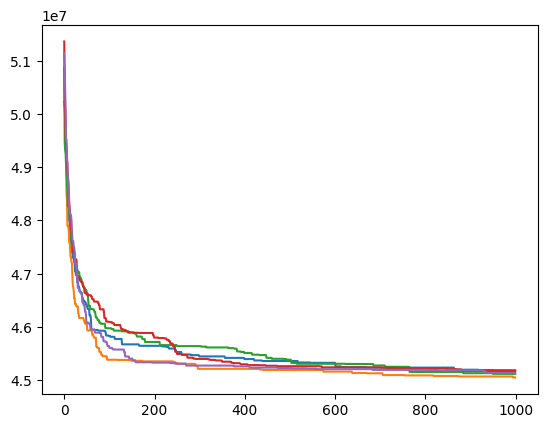

In [107]:
plt.plot(results)
plt.show()

In [13]:
par1 = ga_alg.population[7]
par2 = ga_alg.population[9]

np.random.seed(134)
off1, off2 = cross_order(par1, par2)

print("Off1's Sim. with par1 {:.1f}%".format(np.sum(off1 == par1)/len(par1)*100))
print("Off1's Sim. with par2 {:.1f}%".format(np.sum(off1 == par2)/len(par2)*100))

print("Off2's Sim. with par1 {:.1f}%".format(np.sum(off2 == par1)/len(par1)*100))
print("Off2's Sim. with par2 {:.1f}%".format(np.sum(off2 == par2)/len(par2)*100))

print("par1's Sim. with par2 {:.1f}%".format(np.sum(par1 == par2)/len(par1)*100))



Off1's Sim. with par1 50.0%
Off1's Sim. with par2 0.0%
Off2's Sim. with par1 0.8%
Off2's Sim. with par2 50.4%
par1's Sim. with par2 0.0%


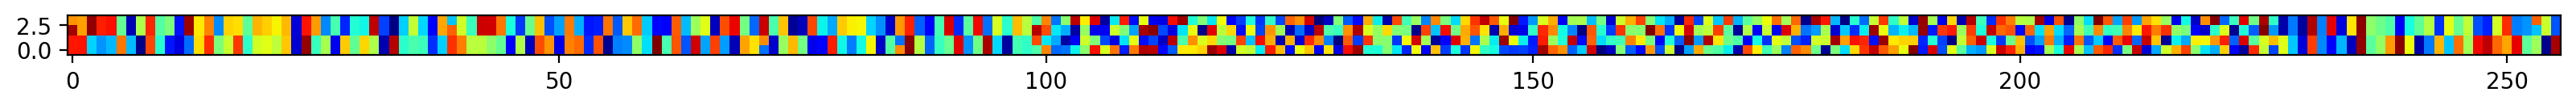

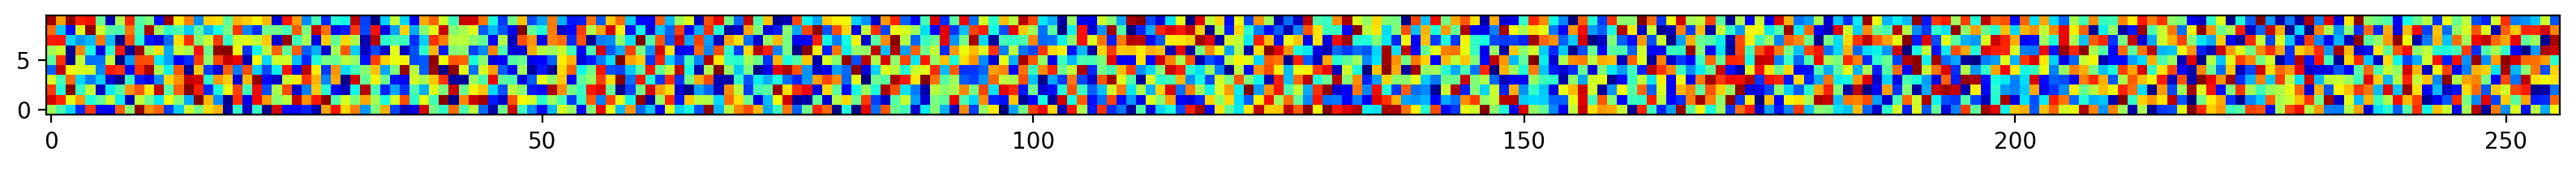

In [26]:
z = [
    par1,
    off1,
    par2,
    off2
]

import matplotlib as mpl
from matplotlib import pyplot as plt

plt.figure(figsize=(20,2), dpi=200)
plt.imshow(z,interpolation='none',cmap=plt.cm.jet,origin='lower') 
plt.show()

z = [
    par1,
    off2,
    par2,
    off1
]
plt.figure(figsize=(20,6), dpi=200)
plt.imshow(ga_alg.population,interpolation='none',cmap=plt.cm.jet,origin='lower') 
plt.show()

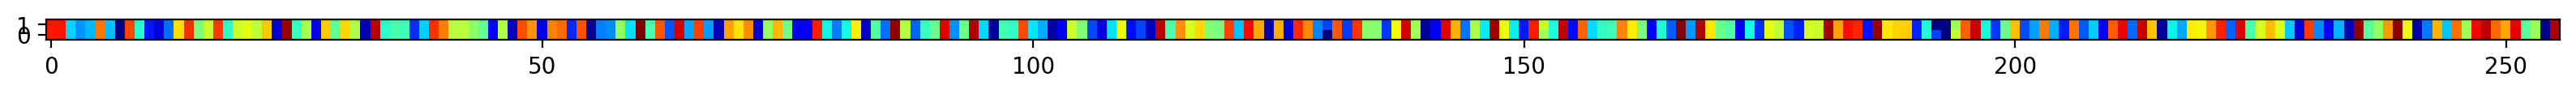

mutOff1's Sim. with Off1 98.4%
mutOff2's Sim. with Off2 99.2%


array([130, 152, 192, 194])

In [25]:
mutoff1 = mut_swap(off1, inplace=False)
mutoff1 = mut_swap(mutoff1, inplace=True)
mutoff2 = mut_swap(off2, inplace=False)

z = [
    off1,
    mutoff1
]
plt.figure(figsize=(20,2), dpi=200)
plt.imshow(z,interpolation='none',cmap=plt.cm.jet,origin='lower') 
plt.show()

print("mutOff1's Sim. with Off1 {:.1f}%".format(np.sum(mutoff1 == off1)/len(mutoff1)*100))
print("mutOff2's Sim. with Off2 {:.1f}%".format(np.sum(mutoff2 == off2)/len(mutoff2)*100))

[2 7 3 9 3 6 3 4 6 7 1 6 6 7 3 6 9 1 1 8]
[3 9 7 6 4 1 8 2 5 0]


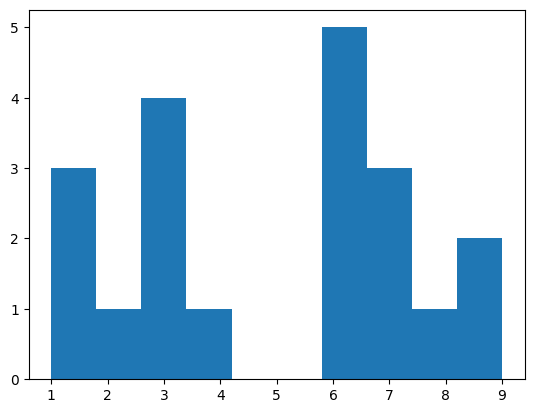

[51146850 52480752 52512752 52868952 53320460 53405424 53665032 53684276
 54299522 54559006]


In [84]:
sel_pars = [list(selection_tournament(ga_alg.fitness)) for i in range(ga_alg.pop_size)]

sel_pars = np.reshape(sel_pars, (2*ga_alg.pop_size))

sort_sol = np.argsort(ga_alg.fitness)

print(sel_pars)

print(sort_sol)

plt.hist(sel_pars, bins=ga_alg.pop_size)
plt.show()


print(ga_alg.fitness[sort_sol])